In [1]:
#!pip uninstall tensorflow
!pip install opencv-python



[notice] A new release of pip is available: 24.2 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input
from tensorflow.keras.models import Model

In [3]:
# Load Dataset
DATA_DIR = "./images/"  # Adjust based on dataset location
METADATA_PATH = "HAM10000_metadata.csv"
df = pd.read_csv(METADATA_PATH)

In [4]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   lesion_id                     0 non-null      object 
 1   image_id                      0 non-null      object 
 2   dx                            0 non-null      object 
 3   dx_type                       0 non-null      object 
 4   age                           0 non-null      float64
 5   sex                           0 non-null      float64
 6   risk_level                    0 non-null      int64  
 7   localization_acral            0 non-null      bool   
 8   localization_back             0 non-null      bool   
 9   localization_chest            0 non-null      bool   
 10  localization_ear              0 non-null      bool   
 11  localization_face             0 non-null      bool   
 12  localization_foot             0 non-null      bool   
 13  localization_genital  

In [6]:
df.shape

(10015, 7)

In [56]:
df.describe()

,age,sex,risk_level
count,0.0,0.0,0.0
mean,NaN,NaN,NaN
std,NaN,NaN,NaN
min,NaN,NaN,NaN
25%,NaN,NaN,NaN
50%,NaN,NaN,NaN
75%,NaN,NaN,NaN
max,NaN,NaN,NaN


In [55]:
df.isnull().sum()

lesion_id                       0
image_id                        0
dx                              0
dx_type                         0
age                             0
sex                             0
risk_level                      0
localization_acral              0
localization_back               0
localization_chest              0
localization_ear                0
localization_face               0
localization_foot               0
localization_genital            0
localization_hand               0
localization_lower extremity    0
localization_neck               0
localization_scalp              0
localization_trunk              0
localization_unknown            0
localization_upper extremity    0
dtype: int64

In [54]:
df.dropna(inplace=True)

In [53]:
df.isnull().sum()

lesion_id                          0
image_id                           0
dx                                 0
dx_type                            0
age                                0
sex                             9958
risk_level                         0
localization_acral                 0
localization_back                  0
localization_chest                 0
localization_ear                   0
localization_face                  0
localization_foot                  0
localization_genital               0
localization_hand                  0
localization_lower extremity       0
localization_neck                  0
localization_scalp                 0
localization_trunk                 0
localization_unknown               0
localization_upper extremity       0
dtype: int64

In [12]:
df.shape

(9958, 7)

In [50]:
df['dx'].nunique()

7

In [52]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,risk_level,localization_acral,localization_back,localization_chest,...,localization_face,localization_foot,localization_genital,localization_hand,localization_lower extremity,localization_neck,localization_scalp,localization_trunk,localization_unknown,localization_upper extremity
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,NaN,0,False,False,False,...,False,False,False,False,False,False,True,False,False,False
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,NaN,0,False,False,False,...,False,False,False,False,False,False,True,False,False,False
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,NaN,0,False,False,False,...,False,False,False,False,False,False,True,False,False,False
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,NaN,0,False,False,False,...,False,False,False,False,False,False,True,False,False,False
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,NaN,0,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [17]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}
base_skin_dir = '../input/skin-cancer-mnist-ham10000'

In [51]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,risk_level,localization_acral,localization_back,localization_chest,...,localization_face,localization_foot,localization_genital,localization_hand,localization_lower extremity,localization_neck,localization_scalp,localization_trunk,localization_unknown,localization_upper extremity
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,NaN,0,False,False,False,...,False,False,False,False,False,False,True,False,False,False
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,NaN,0,False,False,False,...,False,False,False,False,False,False,True,False,False,False
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,NaN,0,False,False,False,...,False,False,False,False,False,False,True,False,False,False
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,NaN,0,False,False,False,...,False,False,False,False,False,False,True,False,False,False
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,NaN,0,False,False,False,...,False,False,False,False,False,False,False,False,False,False


EDA

C:\Users\Asus\AppData\Local\Temp\ipykernel_16452\1013143007.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='sex',data=df, palette = 'Paired')
C:\Users\Asus\AppData\Local\Temp\ipykernel_16452\1013143007.py:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.countplot(x='sex',data=df, palette = 'Paired')


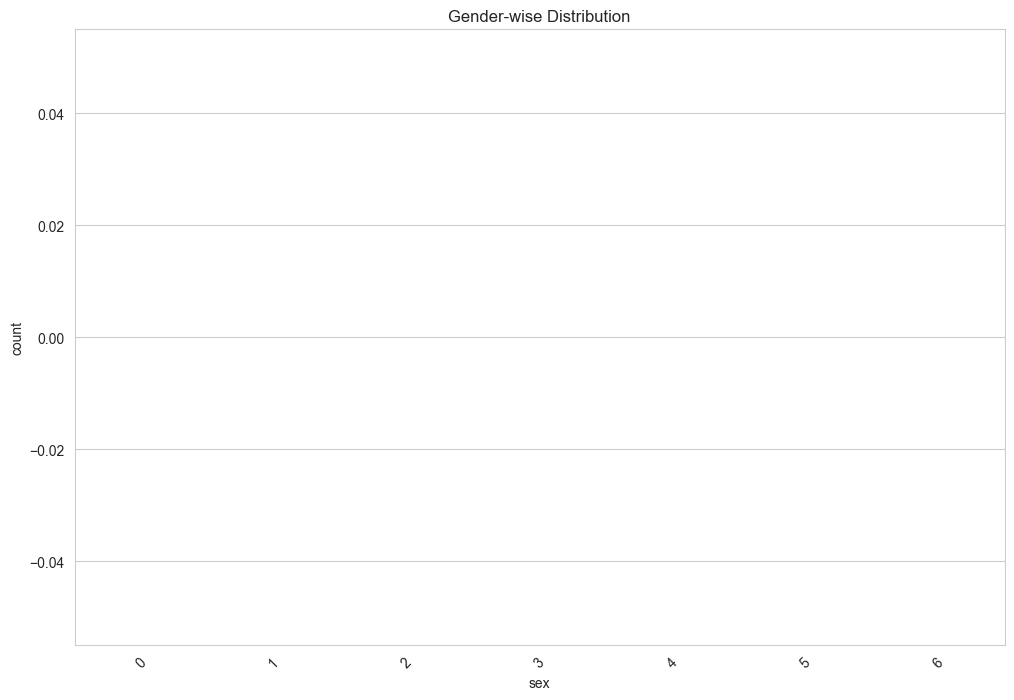

In [49]:
sns.set_style('whitegrid')
colors = ['#87ace8','#e3784d', 'green']
fig,axes = plt.subplots(figsize=(12,8))

ax = sns.countplot(x='sex',data=df, palette = 'Paired')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Gender-wise Distribution')
plt.xticks(rotation=45)
plt.show()

C:\Users\Asus\AppData\Local\Temp\ipykernel_16452\5326602.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


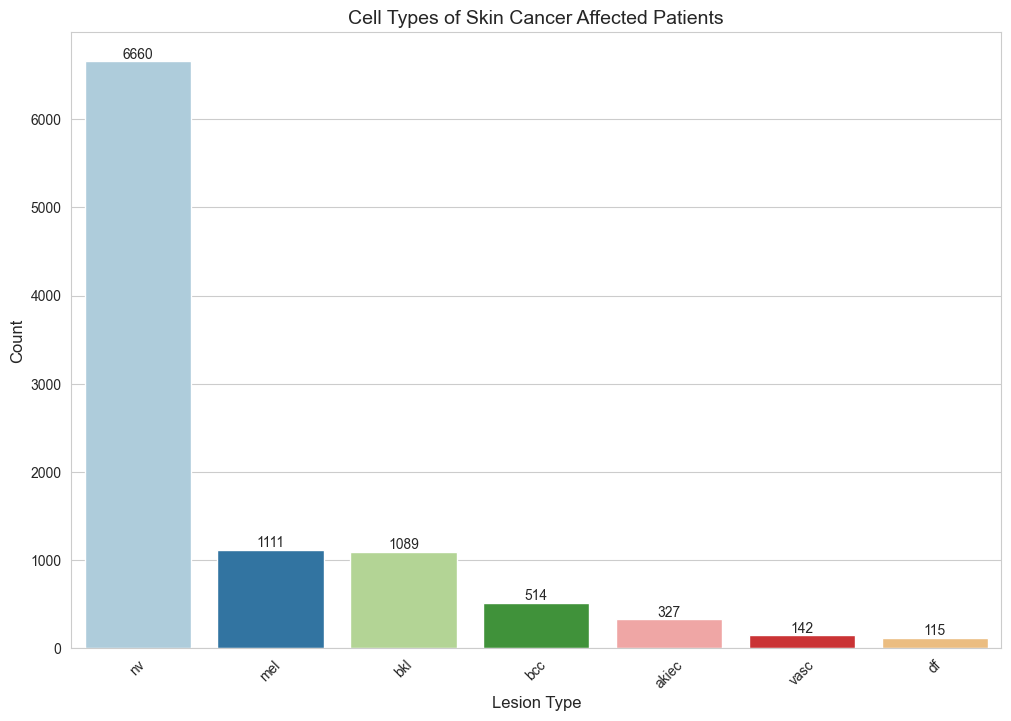

In [20]:

# Set style for seaborn
sns.set_style('whitegrid')

# Define figure size
fig, ax = plt.subplots(figsize=(12, 8))

# Countplot with proper column name ('dx' in HAM10000 dataset)
ax = sns.countplot(
    x='dx',  # Use 'dx' instead of 'cell_type' if using HAM10000
    data=df,
    order=df['dx'].value_counts().index,  # Order bars by frequency
    palette='Paired'
)

# Add bar labels if Matplotlib version supports it
for container in ax.containers:
    ax.bar_label(container, fmt='%d')  # Label with integer count

# Set plot title and labels
plt.title('Cell Types of Skin Cancer Affected Patients', fontsize=14)
plt.xlabel('Lesion Type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.show()


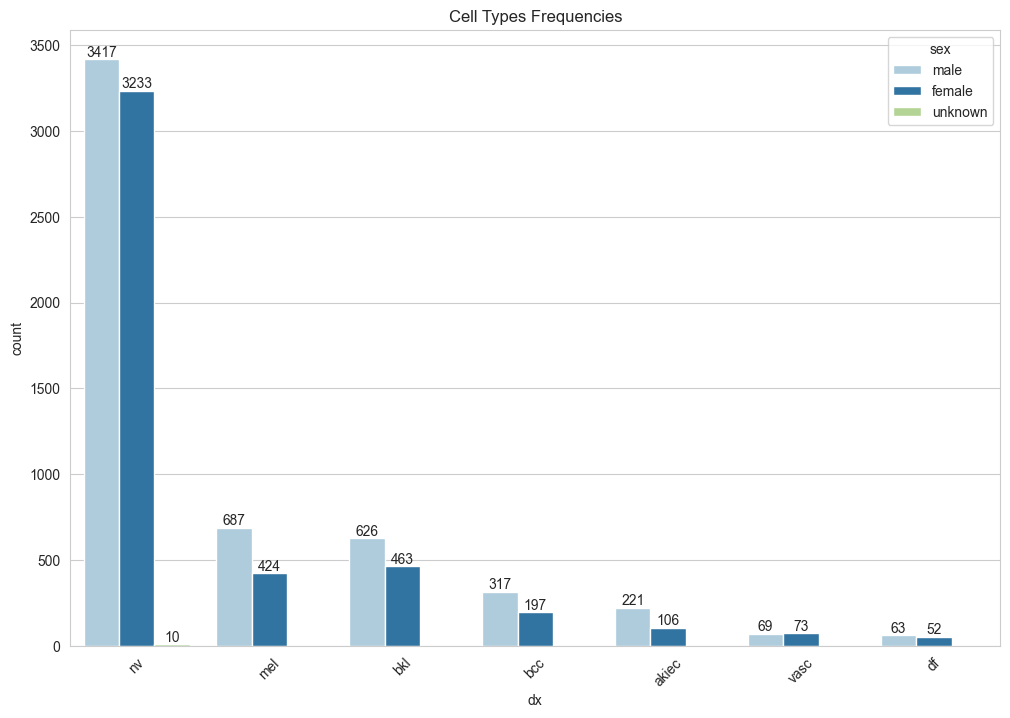

In [25]:
# Set style
sns.set_style('whitegrid')

# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Count plot with ordered categories
ax = sns.countplot(
    x='dx', hue='sex', data=df, 
    order=df['dx'].value_counts().index, 
    palette='Paired'
)

# Add labels to bars
for container in ax.containers:
    ax.bar_label(container)

# Title and formatting
plt.title('Cell Types Frequencies')
plt.xticks(rotation=45)

# Show plot
plt.show()

C:\Users\Asus\AppData\Local\Temp\ipykernel_16452\4047707394.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='dx_type',data=df, order = df['dx_type'].value_counts().index, palette = 'flare')


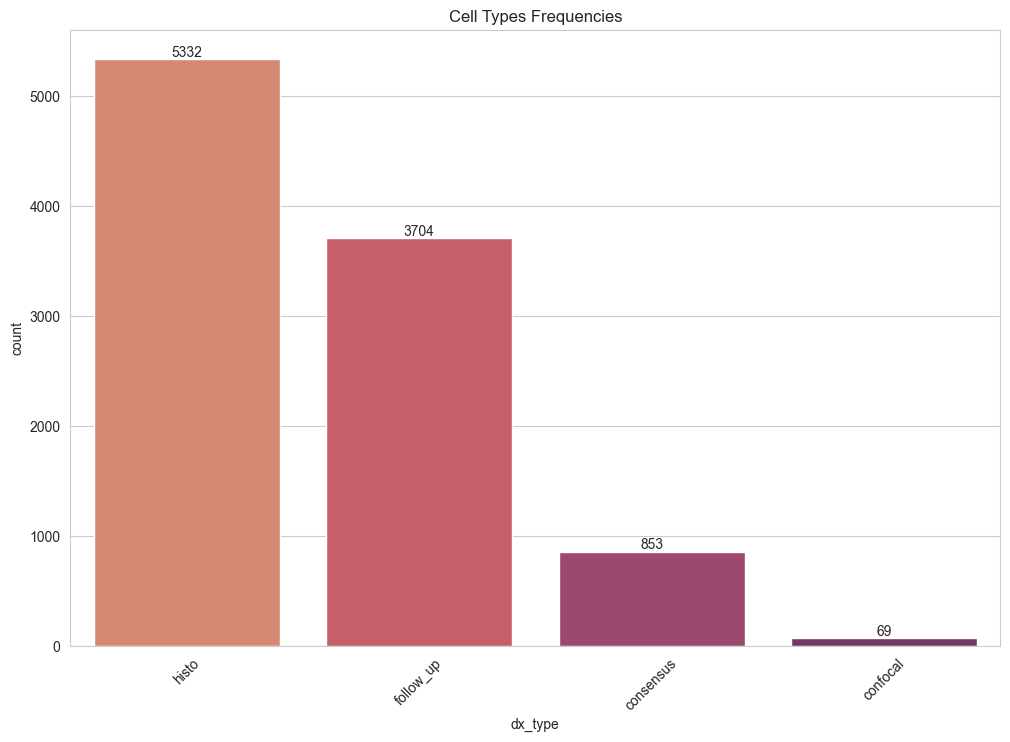

In [26]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.countplot(x='dx_type',data=df, order = df['dx_type'].value_counts().index, palette = 'flare')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Cell Types Frequencies')
plt.xticks(rotation=45)
plt.show()

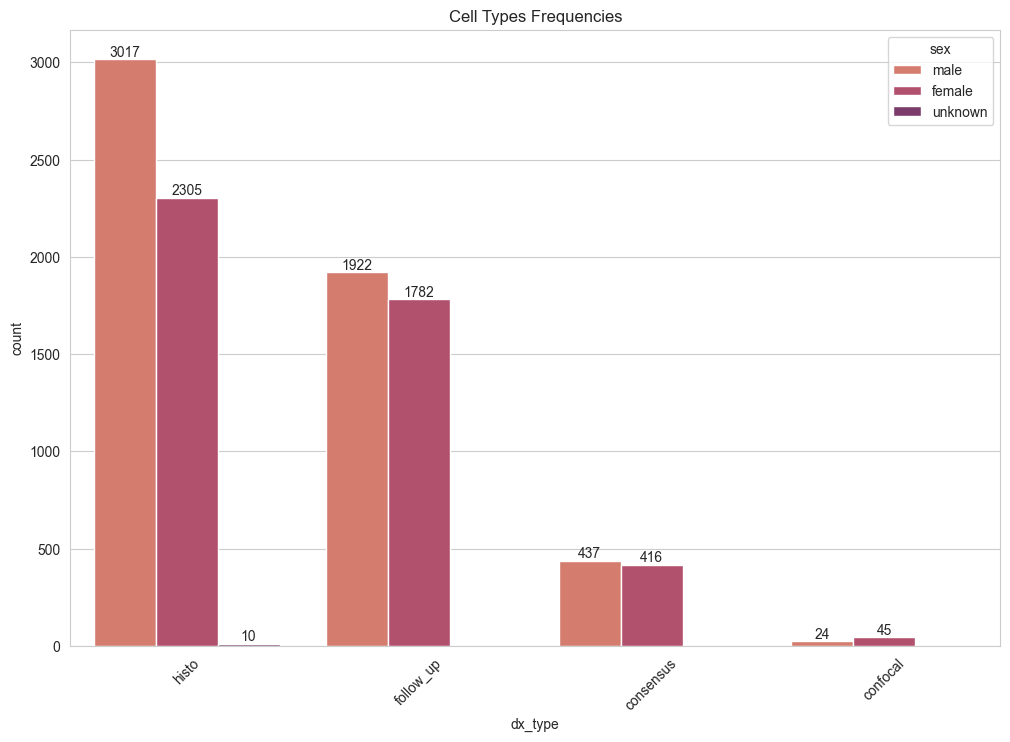

In [27]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.countplot(x='dx_type',hue='sex', data=df, order = df['dx_type'].value_counts().index, palette = 'flare')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Cell Types Frequencies')
plt.xticks(rotation=45)
plt.show()

C:\Users\Asus\AppData\Local\Temp\ipykernel_16452\1969139068.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='localization',data=df, order = df['localization'].value_counts().index, palette = 'crest')


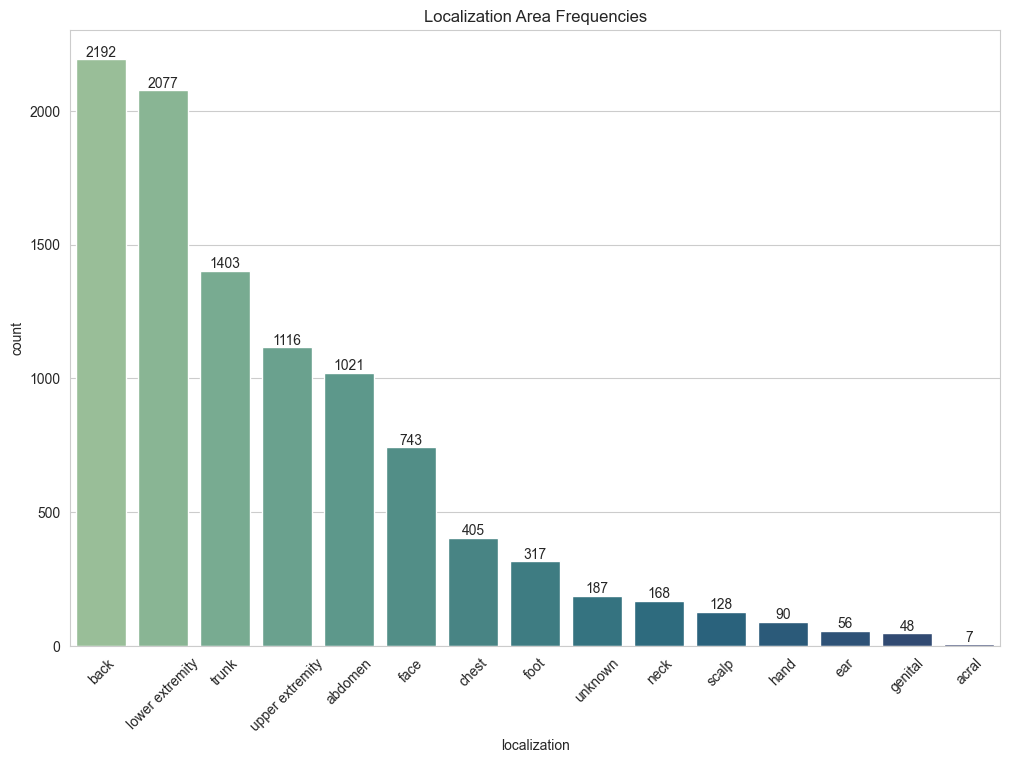

In [28]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.countplot(x='localization',data=df, order = df['localization'].value_counts().index, palette = 'crest')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Localization Area Frequencies')
plt.xticks(rotation=45)
plt.show()

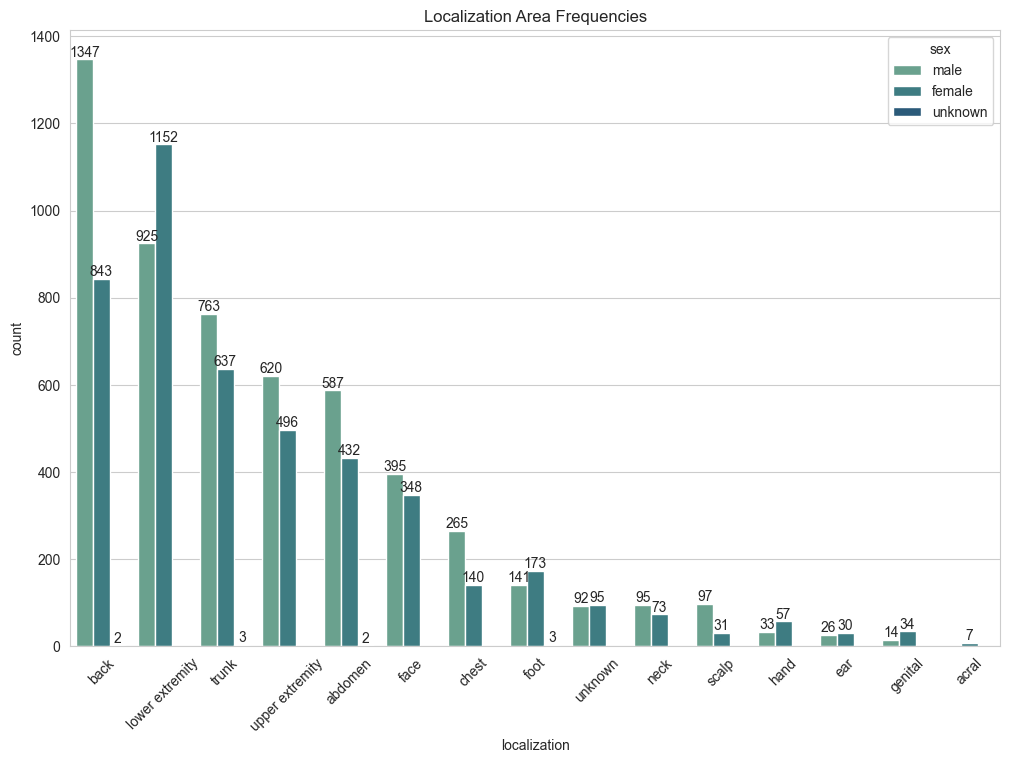

In [29]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.countplot(x='localization',hue='sex', data=df, order = df['localization'].value_counts().index, palette = 'crest')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Localization Area Frequencies')
plt.xticks(rotation=45)
plt.show()

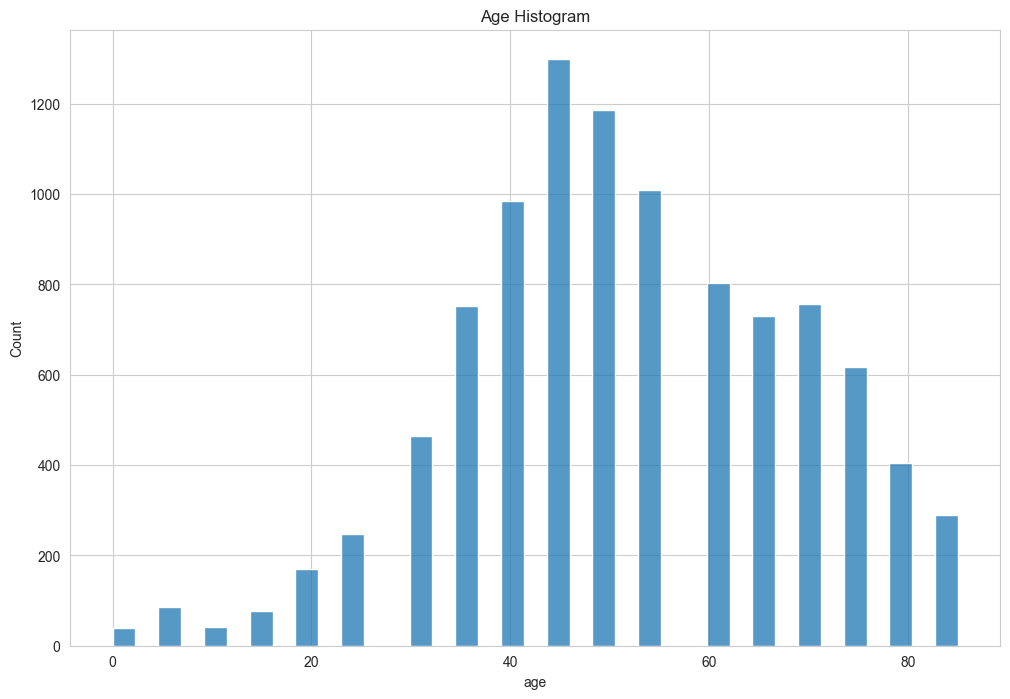

In [30]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.histplot(data=df, x='age')
plt.title('Age Histogram')
plt.show()

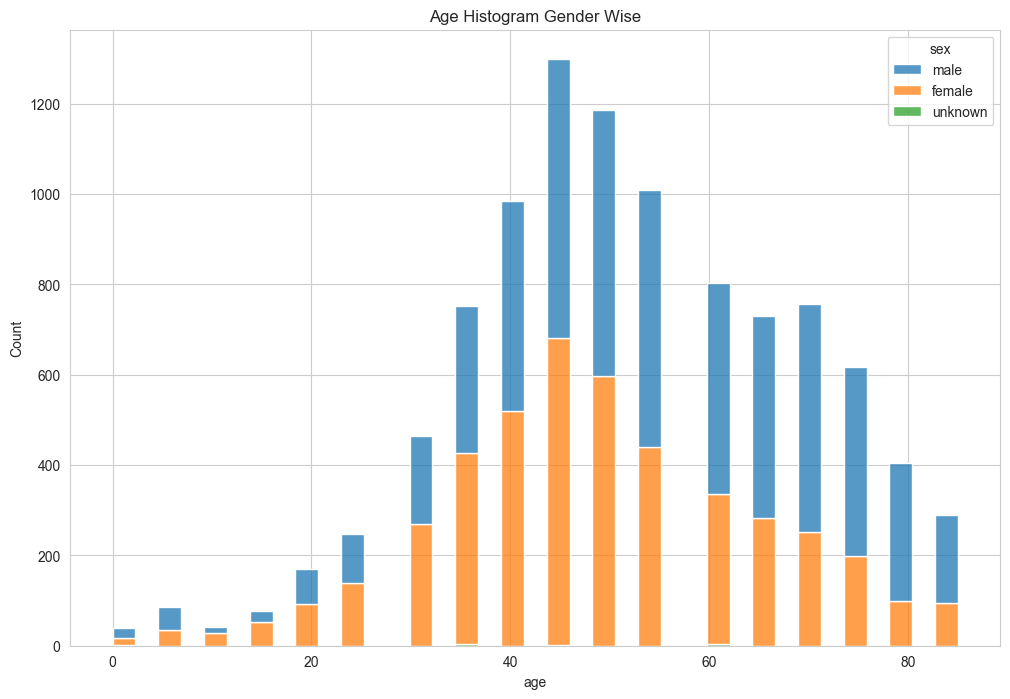

In [31]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.histplot(data=df, x='age',hue='sex',multiple='stack')
plt.title('Age Histogram Gender Wise')
plt.show()

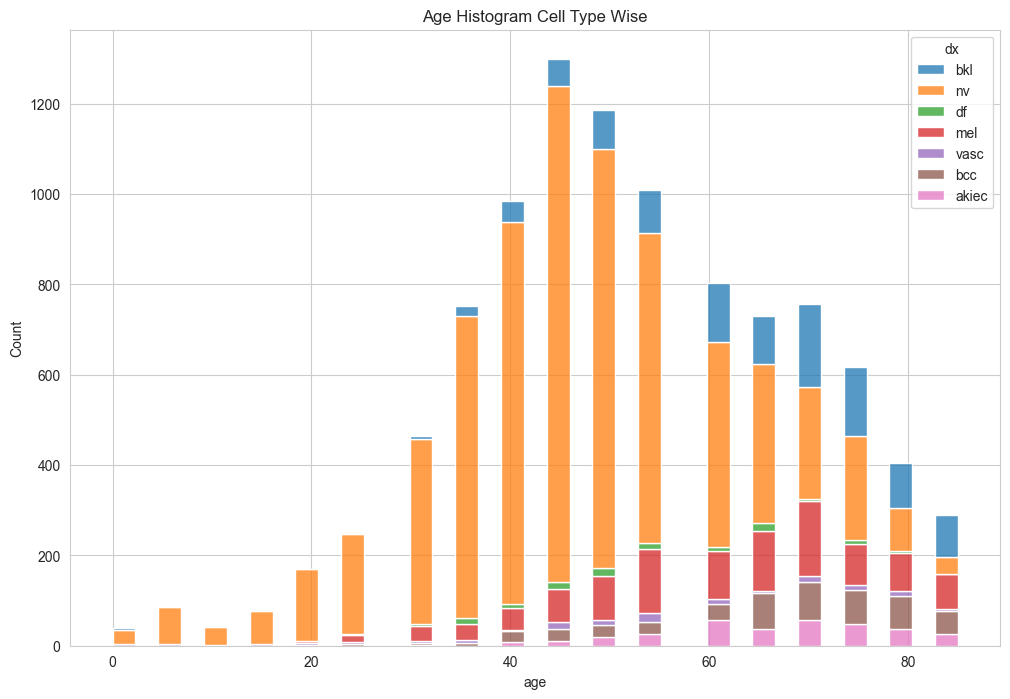

In [33]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.histplot(data=df, x='age',hue='dx',multiple='stack')
plt.title('Age Histogram Cell Type Wise')
plt.show()

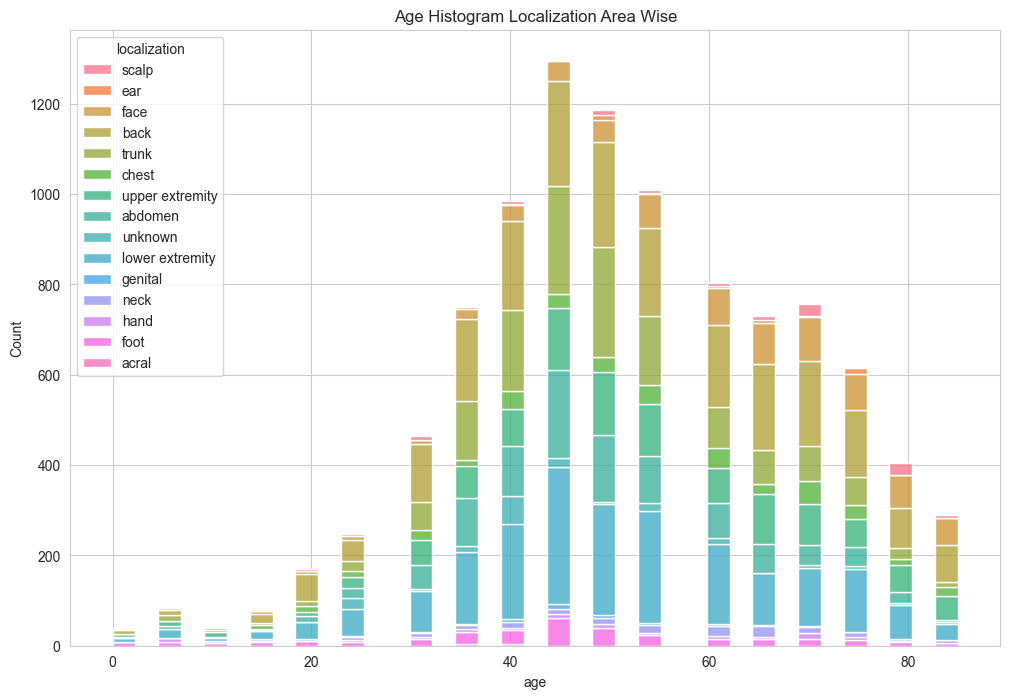

In [34]:
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,8))
ax = sns.histplot(data=df, x='age',hue='localization',multiple='stack')
plt.title('Age Histogram Localization Area Wise')
plt.show()

### Feature Engineering

In [35]:
# Define risk level mapping
risk_mapping = {
    'akiec': 2,  # High Risk
    'mel': 2,    # High Risk
    'bcc': 1,    # Moderate Risk
    'bkl': 0,    # Low Risk
    'df': 0,     # Low Risk
    'nv': 0,     # Low Risk
    'vasc': 0    # Low Risk
}

# Apply mapping
df['risk_level'] = df['dx'].map(risk_mapping)
df[['dx', 'risk_level']].head()


,dx,risk_level
0,bkl,0
1,bkl,0
2,bkl,0
3,bkl,0
4,bkl,0


In [37]:
#  Encoding
df['sex'] = df['sex'].map({'male': 0, 'female': 1,'unknown': 2})


In [48]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,risk_level,localization_acral,localization_back,localization_chest,...,localization_face,localization_foot,localization_genital,localization_hand,localization_lower extremity,localization_neck,localization_scalp,localization_trunk,localization_unknown,localization_upper extremity
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,NaN,0,False,False,False,...,False,False,False,False,False,False,True,False,False,False
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,NaN,0,False,False,False,...,False,False,False,False,False,False,True,False,False,False
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,NaN,0,False,False,False,...,False,False,False,False,False,False,True,False,False,False
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,NaN,0,False,False,False,...,False,False,False,False,False,False,True,False,False,False
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,NaN,0,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [45]:
#One hot Encoding
df = pd.get_dummies(df, columns=['localization'], drop_first=True)
df.head()

KeyError: "None of [Index(['localization'], dtype='object')] are in the [columns]"